In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time, sys, os

# test the ability to import alexmods
from alexmods import smhr
from alexmods.smhutils import element_to_atomic_number, mkdtemp
from alexmods.linelists import LineList
import alexmods.smhr.radiative_transfer.moog as rt
from alexmods.smhr.photospheres.abundances import asplund_2009 as solar_composition

In [3]:
interpolator = smhr.photospheres.interpolator()
marcs_interpolator = smhr.photospheres.marcs_interp() #interpolator("marcs")
outdir = "/Users/xwou/Documents/Research/MIT/sp2020/analysis/Al_linelist_tests"

2020-09-01 12:57:28,413 [DEBUG   ] Initialising CASTELLI/KURUCZ photosphere interpolator


In [4]:
global_isotopes = {
    "Ba": {134: 0.0, 135: 0.37, 136: 0.0, 137: 0.351, 138: 0.279},
    "C-C": {1212: 0.9, 1213: 0.1},
    "C-N": {1214: 0.9, 1314: 0.1},
    "H-C": {112: 0.9, 113: 0.1},
    "Eu": {151: 0.467, 153: 0.533}
}

In [27]:
def make_photosphere(Teff, logg, vt, MH, alpha=0.4):
    photosphere = interpolator(Teff, logg, MH, alpha)
    photosphere.meta["stellar_parameters"]["microturbulence"] = vt
    return photosphere

def make_name(Teff, logg, vt, MH, alpha, prefix="", suffix=".npy",
              elems=None, XFes=None):
    sign = "m" if MH < 0 else "p"
    if elems is None:
        return "{}T{:.0f}_g{:02.0f}_v{:02.0f}_{}{:02.0f}_a{:.0f}{}".format(
            prefix,
            Teff, int(logg*10), int(vt*10), sign, abs(MH*10), int(alpha*10), 
            suffix)
    assert len(elems) == len(XFes)
    fmt = "{}T{:.0f}_g{:02.0f}_v{:02.0f}_{}{:02.0f}_a{:.0f}"
    for elem in elems:
        fmt += "_{}{{:+3.2f}}".format(elem)
    return fmt.format(
        prefix,
        Teff, int(logg*10), int(vt*10), sign, abs(MH*10), int(alpha*10), 
        *XFes)+suffix

def make_marcs_photosphere(Teff, logg, vt, MH):
    photosphere = marcs_interpolator(Teff, logg, MH)
    photosphere.meta["stellar_parameters"]["microturbulence"] = vt
    return photosphere

def CrFe_func(feh):
    return 0.144 + 0.129 * feh
def MnFe_func(feh):
    return -0.234 + 0.096 * feh

def make_abundances(MH, aFe, XFes, elems=[13]):
    """ Converts [X/Fe] to logeps, using MH as [Fe/H] """
    # Cr, Mn: varies with MH, fit using Roederer+2014
    # O, Si, Ti, Mg, Ca: vary with aFe
    # K, Al: hardcoded to mean value in Roederer+2014 of +0.4, -0.65 (Altered! Just K now; varying Al)
    # Ba: hardcoded to mean value in Yong+2013 of -0.57
    # C, Na, Co, Ni, V, Sc, Ce, Nd, Eu, and other elements are solar ratio
    assert len(XFes) == len(elems)
    def make_logeps(elem, XFe):
        return XFe + MH + solar_composition(elem)
    all_elems = ["Fe", "Cr", "Mn", "O", "Si", "Mg", "Ca", "Ti", "K", "Ba"] + list(elems)
    assert len(all_elems) == len(np.unique(all_elems))
    all_XFes = [0.0, CrFe_func(MH), MnFe_func(MH), aFe, aFe, aFe, aFe, aFe, 0.4, -0.57] + list(XFes)
    
    all_Zs = [element_to_atomic_number(el) for el in all_elems]
    all_logeps = [make_logeps(elem, XFe) for elem, XFe in zip(all_elems, all_XFes)]
    abundances = dict(zip(all_Zs, all_logeps))
    return abundances

In [38]:
# Modified from the example code
start0 = time.time()
Tarr = np.arange(4000, 5500, 250)
garr = np.arange(0.0, 4.1, 0.5)
Marr = np.arange(-5.5, 0.01, 0.5)
aarr = np.array([0.0, 0.4])
listarr = ["Al3944.moog","Al3944_KhfsnoC2.moog","Al3944_MhfsnoC2.moog","Al3944_feadj.moog"]
alarr = np.array([-5, -0.75 ,-0.7, -0.65, -0.6, -0.55])
T = Tarr[1]
g = garr[0]
v = 2.10
M = Marr[5]
a = aarr[1]
al = alarr[1]
allist = listarr[1]
listdir = "/Users/xwou/Dropbox/20200609_smhr"

# Everything solar version
# abundances = None
# outfname = make_name(T, g, v, M, a)
# twd = make_name(T, g, v, M, a, prefix="/tmp/", suffix="")

# Varying Al version
XFes = [al]
elems=["Al"]
assert len(XFes) == len(elems), (len(XFes), len(elems), XFes)

abundances = make_abundances(M, a, XFes, elems)
outfname = make_name(T, g, v, M, a, elems=elems, XFes=XFes)
twd = mkdtemp(dir="/tmp/")
#

if not os.path.exists(twd): os.makedirs(twd)
    
print("Writing to {}".format(outfname))
print("twd = {}".format(twd))
print("making photosphere",T,g,v,M,a)
photosphere = make_photosphere(T, g, v, M, a)

print("synthesizing {}".format(outfname))
ll = LineList.read(os.path.join(listdir,allist))
start = time.time()
spectra = rt.synthesize(photosphere, ll, twd=twd,
                        timeout=-1,
                        scat=0,damping=1,
                        abundances=abundances, isotopes=global_isotopes)
spec = spectra[0]
wave, flux, text = spec[0], spec[1], spec[2]
print("succeeded with {} points in {:.1f}s".format(len(wave), time.time()-start))
np.save(os.path.join(outdir, outfname), np.vstack([wave, flux]).T)
print("saved to {}".format(outfname))
print("Total took {:.1f}s".format(time.time()-start0))
print("Removing temporary directory except model.in and batch.par")
os.remove(os.path.join(twd,"lines.in"))
os.remove(os.path.join(twd,"synth.std.out"))
os.remove(os.path.join(twd,"synth.sum.out"))

2020-09-01 23:59:09,063 [DEBUG   ] Executing MOOG input file: /tmp/tmp_wnkkbu3/batch.par


Writing to T4250_g00_v21_m30_a4_Al-0.75.npy
twd = /tmp/tmp_wnkkbu3
making photosphere 4250 0.0 2.1 -3.0 0.4
synthesizing T4250_g00_v21_m30_a4_Al-0.75.npy
succeeded with 1001 points in 0.4s
saved to T4250_g00_v21_m30_a4_Al-0.75.npy
Total took 0.5s
Removing temporary directory except model.in and batch.par


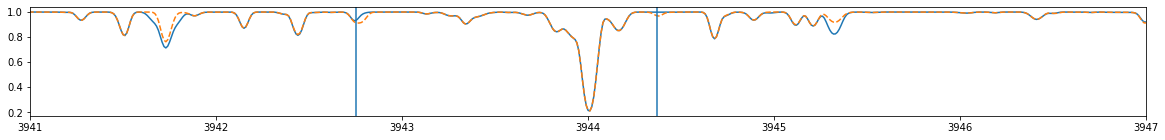

In [55]:
# Loading the out put 
test_load1 = np.load('Al_linelist_tests/T4250_g00_v21_m30_a4_Al-5.0.npy')
test_load2 = np.load('Al_linelist_tests/T4250_g00_v21_m30_a4_Al-0.75_O.npy')
test_load3 = np.load('Al_linelist_tests/T4250_g00_v21_m30_a4_Al-0.75_K.npy')
test_load4 = np.load('Al_linelist_tests/T4250_g00_v21_m30_a4_Al-0.65.npy')
test_load5 = np.load('Al_linelist_tests/T4250_g00_v21_m30_a4_Al-0.60.npy')
test_load6 = np.load('Al_linelist_tests/T4250_g00_v21_m30_a4_Al-0.55.npy')

plt.figure(figsize=[20,2])
# plt.plot(test_load1[:,0],test_load1[:,1])
plt.plot(test_load2[:,0],test_load2[:,1])
plt.plot(test_load3[:,0],test_load3[:,1],'--')
# plt.plot(test_load4[:,0],test_load4[:,1])
# plt.plot(test_load5[:,0],test_load5[:,1])
# plt.plot(test_load6[:,0],test_load6[:,1])
plt.axvline(3942.75)
plt.axvline(3944.37)
plt.xlim([3941,3947])
plt.show()

In [ ]:
# Alex's example code
start0 = time.time()
T, g, v, M, a  = [float(sys.argv[i]) for i in [1,2,3,4,5]]
if len(sys.argv) == 15:
    XFes = [float(sys.argv[i]) for i in range(6, len(sys.argv))]
    elems=["C", "Mg", "Ca", "Ti", "Sr", "Ba", "Ce", "Nd", "Eu"]
    assert len(XFes) == len(elems), (len(XFes), len(elems), XFes)

    abundances = make_abundances(M, a, XFes, elems)
    outfname = make_name(T, g, v, M, a, elems=elems, XFes=XFes)
    twd = mkdtemp(dir="/data001/aji/moog_grids/tmp/")
else:
    assert len(sys.argv) == 6, sys.argv
    abundances = None
    outfname = make_name(T, g, v, M, a)
    twd = make_name(T, g, v, M, a, prefix="/data001/aji/moog_grids/tmp/", suffix="")
if not os.path.exists(twd): os.makedirs(twd)

print("Writing to {}".format(outfname))
print("twd = {}".format(twd))
print("making photosphere",T,g,v,M,a)
photosphere = make_photosphere(T, g, v, M, a)

#Tarr = np.arange(4000, 5751, 250)
#garr = np.arange(0.0, 4.1, 0.5)
#Marr = np.arange(-5.5, 0.01, 0.5)
#aarr = np.array([0.0, 0.4])
#T = Tarr[0]
#g = garr[1]
#v = 1.50
#M = Marr[4]
#a = aarr[1]

print("synthesizing {}".format(outfname))
ll = LineList.read("big_list.moog")
#ll = LineList.read("test_linelist.moog")
start = time.time()
spectra = rt.synthesize(photosphere, ll, twd=twd,
                        timeout=-1,
                        scat=0,damping=1,
                        abundances=abundances, isotopes=global_isotopes)
spec = spectra[0]
wave, flux, text = spec[0], spec[1], spec[2]
print("succeeded with {} points in {:.1f}s".format(len(wave), time.time()-start))
np.save(os.path.join(outdir, outfname), np.vstack([wave, flux]).T)
print("saved to {}".format(outfname))
print("Total took {:.1f}s".format(time.time()-start0))
print("Removing temporary directory except model.in and batch.par")
os.remove(os.path.join(twd,"lines.in"))
os.remove(os.path.join(twd,"synth.std.out"))
os.remove(os.path.join(twd,"synth.sum.out"))